In [16]:
import numpy as np
import scipy as sp
import phasepy
import pandas as pd

### Pregunta 1 
Encontrar datos de equilibrio líquido-vapor a presión constante de un sistema binario compuesto 1 + compuesto 2 a temperaturas y presiones bajo el punto crítico de ambos compuestos. La idea es que los datos esten a presiones bajo los 5 bar y que se forme un azeótropo. Para este sistema:

### (a) Ajustamos los parámetros NRTL

In [17]:
import numpy as np
from phasepy import mixture, component, preos
from phasepy.equilibrium import flash
import matplotlib.pyplot as plt
# Al importar preos estaríamos haciendo el método phi-phi

In [18]:
# Parámetros antoine 3-p (N)
# El rango de temperatura es: 377.93 y 

A_pent = 9.95679
B_pent = 2988.03935
C_pent = -110.669

A_non = 9.35414
B_non = 3293.56476
C_non = -71.355

In [19]:
pentanol = component(name = '1-pentanol', Tc = 588.15, Pc = 39.09, Zc = 0.262 , Vc = 326.00, w = 0.579, 
               Ant =  [A_pent, B_pent, C_pent], 
               GC = {'CH3':1, 'CH2':4,'OH(P)':1})

nonane = component(name = 'n-nonane', Tc = 594.6, Pc = 22.90, Zc = 0.257, Vc = 555, w = 0.445,
                GC = {'CH3':2, 'CH2':7},
                Ant = [A_non, B_non, C_non])

mix = pentanol + nonane

Trabajando a 40 kPa o 0.4 bar

In [20]:
#Datos de equilibrios de vapor líquido obtenidos de Pedro Susial, Aday Sosa-Rosario, Juan José Rodríguez, Raúl Ríos-Santana (1949).
# «Vapor Pressure and VLE Data Measurements on Ethyl Acetate/Ethanol Binary Systema at 0.1, 0.5 and 0.5 MPA». 
#Journal of Chemical Engineering of Japan, Vol. 44, No. 3, pp. 155-163, 2011.

#Saturation Pressure in bar

df = pd.read_csv('./data_exp/DatosP1_V2.csv')

Pexp = df.iloc[:, 0].to_numpy()
Texp = df.iloc[:, 1].to_numpy()
x1 = df.iloc[:, 2].to_numpy()
x2 = df.iloc[:, 3].to_numpy()
y1 = df.iloc[:, 4].to_numpy()
y2 = df.iloc[:, 5].to_numpy()

#Liquid fraction mole array
Xexp = np.array([x1,x2])

#Vapor fraction mole array
Yexp = np.array([y1,y2])

datavle = (Xexp, Yexp, Texp, Pexp)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


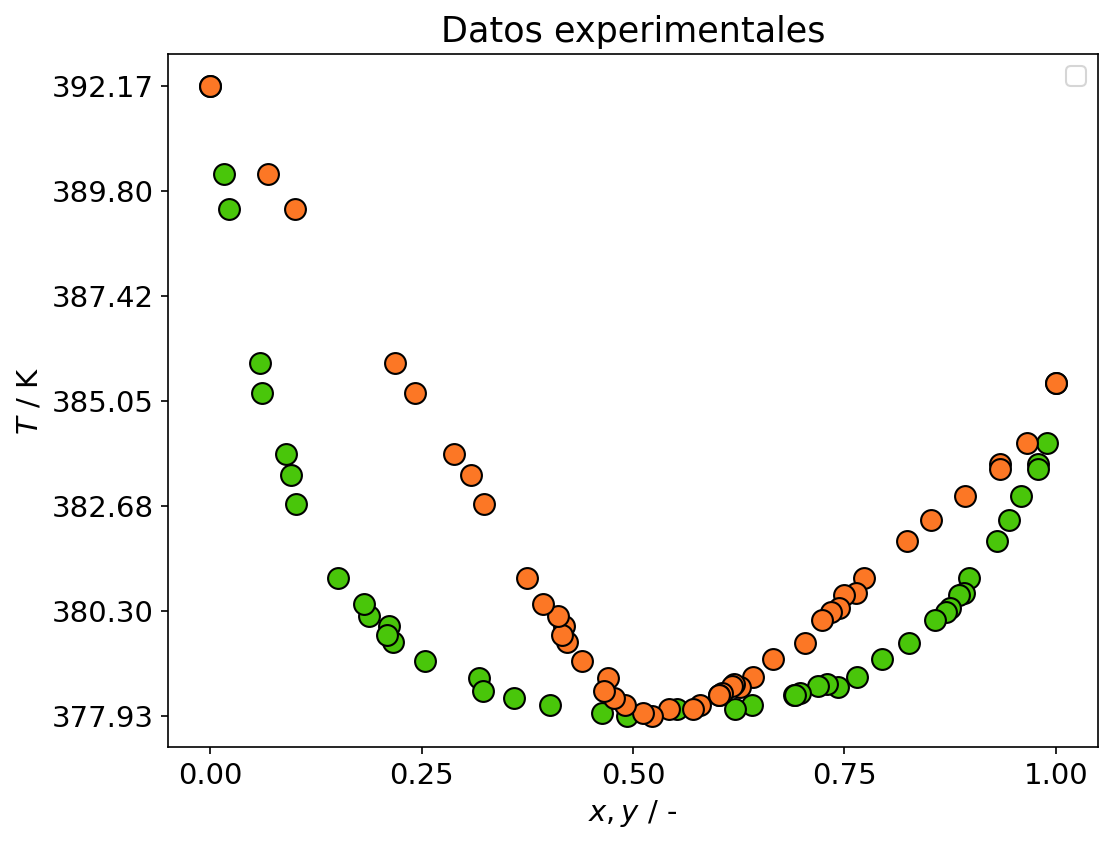

In [21]:
font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = '#49C60A', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = '#FC7725', marker = 'o', edgecolors='black', s=100)

ax.legend(fontsize="small")
plt.title('Datos experimentales')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(min(Texp),max(Texp), 7))

plt.show()

Ahora procedemos con el ajuste de parámetros NRTL

In [22]:
from phasepy.fit import fit_nrtl
mixnrtl = mix.copy()

#Valores iniciales A12, A21
# nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1, alpha]) Cuando hay dependencia de T
nrtl0 = np.array([20.36, -21.47])

# Rutina de optimización
alphafixed = 0.3
a = fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, alpha0 = alphafixed)
print(a)
# Valores optimos
#[-84.77530335, 648.78439102]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00036958208715510635
        x: [ 3.354e+02  3.042e+02]
      nit: 4
      jac: [-8.686e-07 -4.403e-06]
 hess_inv: [[ 4.005e+05  4.139e+05]
            [ 4.139e+05  4.278e+05]]
     nfev: 42
     njev: 14


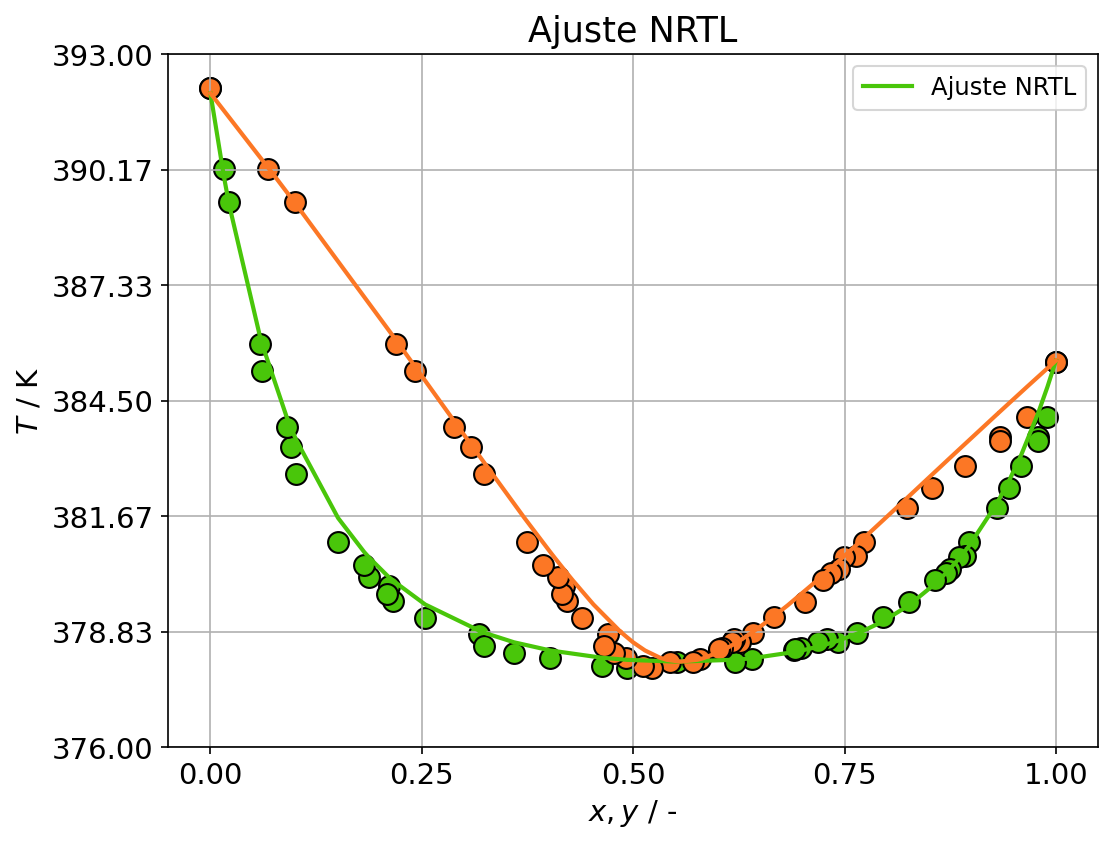

In [23]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

Ynrtl = np.zeros_like(Yexp)
Tnrtl = np.zeros_like(Pexp)

alpha = np.array([[0.0, alphafixed],
                  [alphafixed, 0.0]])

Aij0 = np.array([[0.0, a["x"][0]],
              [a["x"][1], 0.0]])

mix.NRTL(alpha, Aij0)

virialnrtl = virialgamma(mixnrtl, actmodel = 'nrtl')

n = len(Pexp)

for i in range(n):
    Ynrtl[:,i],Tnrtl[i] = bubbleTy(Yexp[:,i], Texp[i],Xexp[:,i], Pexp[i],virialnrtl)

font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = '#49C60A', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = '#FC7725', marker = 'o', edgecolors='black', s=100)
ax.plot(Xexp[0], Tnrtl, color = '#49C60A', linewidth = 2.0, label = "Ajuste NRTL")
ax.plot(Ynrtl[0], Tnrtl, color = '#FC7725', linewidth = 2.0)


ax.legend(fontsize="small")
plt.title('Ajuste NRTL')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(376, 393, 7))
plt.grid()
plt.show()


#### Ahora reportamos los cálculos de coeficiente de fugacidad de la mezcla en fase vapor, compuesto puro y factor de Poyting

In [24]:
mix_fug = logfuge()

NameError: name 'logfuge' is not defined

### (b) Ahora realizamos la predicción de comportamiento con UNIFAC

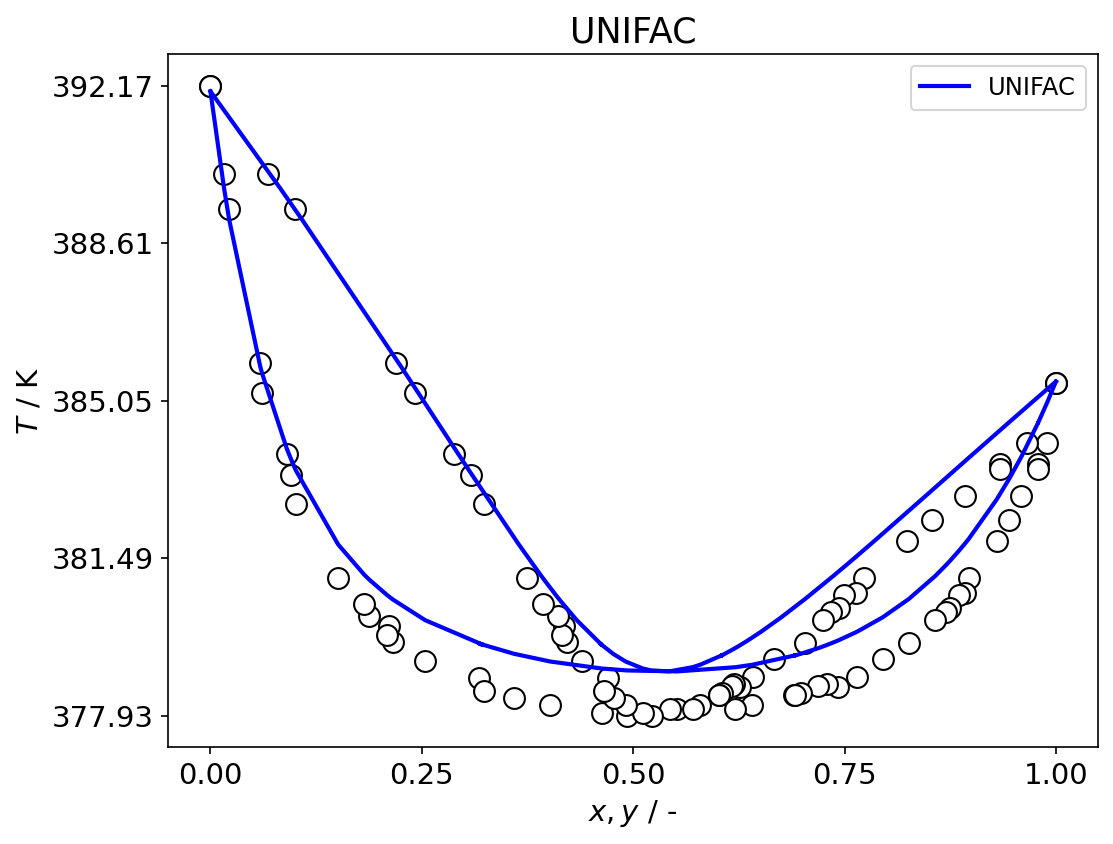

In [ ]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

Yunifac = np.zeros_like(Yexp)
Tunifac = np.zeros_like(Pexp)

mixunifac = mix.copy()
mixunifac.unifac()

A12, A21 = a["x"][0], a["x"][1] 
Aij0 = np.array([[0., A12], [A21, 0.]])

virialunifac = virialgamma(mix, virialmodel='ideal_gas', actmodel='unifac')


n = len(Pexp)

for i in range(n):
    Yunifac[:,i],Tunifac[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialunifac)

font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = 'white', marker = 'o', edgecolors='black', s=100)
ax.scatter(Yexp[0], Texp, color = 'white', marker = 'o', edgecolors='black', s=100)
ax.plot(Xexp[0], Tunifac, color = 'blue', linewidth = 2.0)
ax.plot(Yunifac[0], Tunifac, color = 'blue', linewidth = 2.0, label = 'UNIFAC')


ax.legend(fontsize="small")
plt.title('UNIFAC')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(min(Texp),max(Texp), 5))

plt.show()

### Finalmente, modelamos con Peng-Robinson para las distintas reglas de mezclado

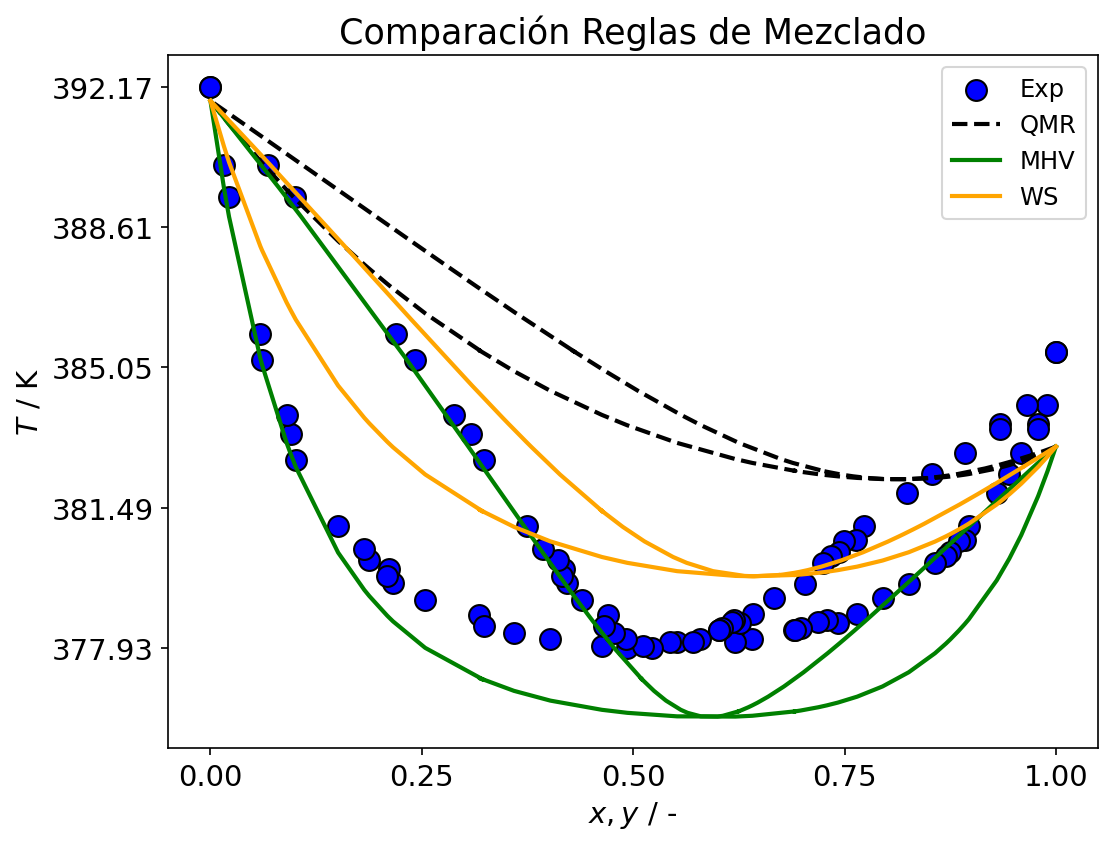

In [ ]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy
mix = pentanol + nonane

alpha = np.array([[0.0, alphafixed],
                  [alphafixed, 0.0]])

Aij0 = np.array([[0.0, a["x"][0]],
              [a["x"][1], 0.0]])

mix.NRTL(alpha, Aij0)

eos_qmr = preos(mix, mixrule='qmr')
eos_mhv = preos(mix, mixrule='mhv_nrtl')
eos_ws = preos(mix, mixrule='ws_nrtl')

# Creamos los vectores vacíos para el vapor según la regla de mezclado
Y_qmr = np.zeros_like(Yexp)
Y_mhv = np.zeros_like(Yexp)
Y_ws = np.zeros_like(Yexp)

# Creamos los vectores vacíos para la temperatura según la regla de mezclado
T_mhv = np.zeros_like(Pexp)
T_qmr = np.zeros_like(Pexp)
T_ws = np.zeros_like(Pexp)


n = len(Pexp)

for i in range(n):
    Y_qmr[:,i],T_qmr[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],eos_qmr)
    Y_mhv[:,i],T_mhv[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],eos_mhv)
    Y_ws[:,i],T_ws[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],eos_ws)

font = {'weight' : 'normal', 'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (8, 6), dpi = 150)
ax.scatter(Xexp[0], Texp, color = 'blue', marker = 'o', edgecolors='black', s=100, label = 'Exp')
ax.scatter(Yexp[0], Texp, color = 'blue', marker = 'o', edgecolors='black', s=100)
ax.plot(Xexp[0], T_qmr, color = 'black', linewidth = 2.0, linestyle = '--')
ax.plot(Y_qmr[0], T_qmr, color = 'black', linewidth = 2.0 , linestyle = '--', label = 'QMR')
ax.plot(Xexp[0], T_mhv, color = 'green', linewidth = 2.0)
ax.plot(Y_mhv[0], T_mhv, color = 'green', linewidth = 2.0, label = 'MHV')
ax.plot(Xexp[0], T_ws, color = 'orange', linewidth = 2.0)
ax.plot(Y_ws[0], T_ws, color = 'orange', linewidth = 2.0, label = 'WS')


ax.legend(fontsize="small")
plt.title('Comparación Reglas de Mezclado')
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x , y$ / -')
ax.xaxis.set_ticks(np.linspace(0, 1, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(min(Texp),max(Texp), 5))

plt.show()

